In [1]:
cd ../..

D:\Users\mrefoyo\Proyectos\Sub-SpaCE_plus


In [2]:
import os
import pickle
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf

from experiments.evaluation.evaluation_utils import load_dataset_for_eval, calculate_metrics_for_dataset, calculate_method_valids

print(tf.__version__)

2.13.0


In [3]:
# datasets = ['CBF', 'chinatown', 'coffee', 'gunpoint', 'ECG200']
DATASETS = ["BasicMotions", "NATOPS", "UWaveGestureLibrary"]
methods = {
    # Basic experimentos
    # "43b17a2e4f21097540adf8600402c5bd32fa60d6": "subspace_gknn_gch",
    # "37a3f06c077321b95960769282152427a7ee48ae": "subspace_gknn_ich", 
    # "86df14d56b66fecfb65d5805107dfe10961ecae9": "subspace_iknn_gch",     
    # "4f40e39bfe0d3da692b5571d87f7ec915c42eba2": "subspace_iknn_ich", 
    
    # Basic experiments only gknn but with lower gamma (0.125)
    # "4d1faa458bab2b8c6ee14d59b824557fcc80d8e3": "subspace_gknn_gch_gamma0125", 
    # "93c0b5f0630a5dbf5d0377a4f3ff03b6868cbda1": "subspace_iknn_gch_gamma0125", 
    
    # Basic experiments New IoS 
    # "e54dcb25b02132166a719885cad2695540450ee6": "subspace_gknn_gch_ios",
    # "9cdb2fb25d7c664d60da7aa23b4c2c0f9ec9548c": "subspace_gknn_ich_ios",
    # "8c29354f168b9852a05523a7c26ab0f4acb30e9b": "subspace_iknn_gch_ios",
    # "b93fe63854fe36f62900cbcae1c00ad499d41f74": "subspace_iknn_ich_ios",
    
    # Sub-SpaCE v2 para fine tuning con optimizacion con canales independientes
    "316686353c28547589d494bcc886c8334329b14e": "subspace_gknn_gch",
    "0f31693cb3d17afd3d67191e82e2bca887075ee6": "subspace_gknn_gch_moremut",
    # "76f8a8271b7ba6d171b7383bce7bbf4d9286d78c": "subspace_gknn_gch_moreit",
    "bba03e82f6c718e1466a06087dd99606de229b40": "subspace_gknn_ich",
    "a246def090b506ff8ba41e861e0464493233b9d1": "subspace_gknn_ich_moremut",
    # "d3b12b6ac5e2ab4e68901859273a55edb14d5590": "subspace_gknn_ich_moreit",
    "cfbb6793595875fa49b7becafefa2ff2df33a2f6": "subspace_gknn_cch",
    "e4a8da55a30853287350d3540873bcb91cb50b70": "subspace_gknn_cch_moremut",
    # "fe0be96f08c5d37950f7ae2c50d7f81fc050c185": "subspace_gknn_cch_moreit"
}

# Get results

In [12]:
from sklearn.preprocessing import MinMaxScaler

def create_fitnes_curve_df(fitness_evolutions, method_name, scale=True):
    if scale:
        scaler = MinMaxScaler()
        scaled_fitness_evolutions = scaler.fit_transform(np.array(fitness_evolutions).T).T
        fitness_df = pd.DataFrame(scaled_fitness_evolutions)
    else:
        fitness_df = pd.DataFrame(np.array(fitness_evolutions))
    # Filter those rows where the last value is 0 (the CF is not valid)
    fitness_df = fitness_df[fitness_df[99]!=0]
    fitness_df = pd.melt(fitness_df.reset_index(), id_vars=['index'], value_vars=fitness_df.columns,
                         var_name='iteration', value_name='fitness')
    fitness_df["method"] = method_name
    return fitness_df

def create_init_fitness_values_df(init_fitness_values, method_name):
    init_fitness_df = pd.DataFrame()
    init_fitness_df['Best Initial Fitness'] = init_fitness_values
    init_fitness_df['Method'] = method_name
    return init_fitness_df

In [13]:
all_fitness_curves_df = pd.DataFrame()
init_fitness_values_df = pd.DataFrame()
for dataset in DATASETS:
    print(f'Calculating fitness curves for {dataset}')
    
    # Load all solutions for the dataset and calculate metrics
    dataset_init_fitness_df = pd.DataFrame()
    dataset_fitness_df = pd.DataFrame()
    cf_solution_dirs = [fname for fname in os.listdir(f'./experiments/results/{dataset}/') if os.path.isdir(f'./experiments/results/{dataset}/{fname}')]
    desired_cf_solution_dirs = [cf_sol_dir for cf_sol_dir in cf_solution_dirs if cf_sol_dir in methods.keys()]
    for i, method_dir_name in enumerate(desired_cf_solution_dirs):
        method_name = methods[method_dir_name]
        print(method_name)
        with open(f'./experiments/results/{dataset}/{method_dir_name}/counterfactuals.pickle', 'rb') as f:
            method_cfs = pickle.load(f)
            counterfactuals = [solution['cf'] for solution in method_cfs]
            original_fitness_evolutions = [solution['fitness_evolution'] for solution in method_cfs]
        # Load params
        with open(f'./experiments/results/{dataset}/{method_dir_name}/params.json', 'r') as json_file:
            method_params = json.load(json_file)
            method_test_indexes = method_params["X_test_indexes"]
            
        # GET FITNESS VALUES
        initial_fitness_list = [fitness_evolution[0] for fitness_evolution in original_fitness_evolutions]

        # Create Fitness evolutions with valid info for getting convergence
        # Keep only the last 100 iterations as this is the max number of iteration used in the experiments.
        fitness_evolutions = [fitness_evolution[-100:] for fitness_evolution in original_fitness_evolutions]
        # Fill with the last existing value at the end in case of early convergence (all mask with the same value)
        fitness_evolutions = [fitness_evolution + [fitness_evolution[-1]]*(100-len(fitness_evolution))
                              if len(fitness_evolution) != 100 else fitness_evolution
                              for fitness_evolution in fitness_evolutions]
            
        # GET VALID COUNTERFACTUALS
        data_tuple, original_classes, model, outlier_calculator, possible_nuns, desired_classes = load_dataset_for_eval(dataset)
        
        # Get the metrics for all methods
        X_train, y_train, X_test, y_test = data_tuple
        valids = calculate_method_valids(model, X_test[method_test_indexes], counterfactuals,
                                         original_classes[method_test_indexes])

        # FILTER NON VALID COUNTERFACTUALS
        valid_fitness_evolutions = [fitness_evolution for fitness_evolution, valid in zip(fitness_evolutions, valids) if valid==True]

        # GET FITNESS CURVES
        fitness_evolutions_df = create_fitnes_curve_df(valid_fitness_evolutions, method_name, scale=False)
        dataset_fitness_df = pd.concat([dataset_fitness_df, fitness_evolutions_df])
        # Get data for initial fitness values
        init_fitness_df = create_init_fitness_values_df(initial_fitness_list, method_name)
        dataset_init_fitness_df = pd.concat([dataset_init_fitness_df, init_fitness_df])

    dataset_fitness_df['dataset'] = dataset
    dataset_init_fitness_df['dataset'] = dataset
    all_fitness_curves_df = pd.concat([all_fitness_curves_df, dataset_fitness_df])
    init_fitness_values_df = pd.concat([init_fitness_values_df, dataset_init_fitness_df])

Calculating fitness curves for BasicMotions
subspace_gknn_gch_moremut


100%|██████████| 40/40 [00:02<00:00, 18.53it/s]


subspace_gknn_gch


100%|██████████| 40/40 [00:01<00:00, 20.91it/s]


subspace_gknn_ich_moremut


100%|██████████| 40/40 [00:01<00:00, 20.73it/s]


subspace_gknn_ich


100%|██████████| 40/40 [00:01<00:00, 20.51it/s]


subspace_gknn_cch


100%|██████████| 40/40 [00:01<00:00, 20.58it/s]


subspace_gknn_cch_moremut


100%|██████████| 40/40 [00:02<00:00, 19.90it/s]


Calculating fitness curves for NATOPS
subspace_gknn_gch_moremut


100%|██████████| 100/100 [00:04<00:00, 20.84it/s]


subspace_gknn_gch


100%|██████████| 100/100 [00:04<00:00, 20.79it/s]


subspace_gknn_ich_moremut


100%|██████████| 100/100 [00:05<00:00, 19.54it/s]


subspace_gknn_ich


100%|██████████| 100/100 [00:04<00:00, 20.57it/s]


subspace_gknn_cch


100%|██████████| 100/100 [00:04<00:00, 20.38it/s]


subspace_gknn_cch_moremut


100%|██████████| 100/100 [00:04<00:00, 20.65it/s]


Calculating fitness curves for UWaveGestureLibrary
subspace_gknn_gch_moremut


100%|██████████| 100/100 [00:04<00:00, 20.65it/s]


subspace_gknn_gch


100%|██████████| 100/100 [00:04<00:00, 20.56it/s]


subspace_gknn_ich_moremut


100%|██████████| 100/100 [00:04<00:00, 20.35it/s]


subspace_gknn_ich


100%|██████████| 100/100 [00:04<00:00, 20.46it/s]


subspace_gknn_cch


100%|██████████| 100/100 [00:04<00:00, 20.47it/s]


subspace_gknn_cch_moremut


100%|██████████| 100/100 [00:04<00:00, 20.31it/s]


In [14]:
all_fitness_curves_df

,index,iteration,fitness,method,dataset
0,0,0,-0.198475,subspace_gknn_gch_moremut,BasicMotions
1,1,0,-0.193465,subspace_gknn_gch_moremut,BasicMotions
2,2,0,-0.158507,subspace_gknn_gch_moremut,BasicMotions
3,3,0,-0.180178,subspace_gknn_gch_moremut,BasicMotions
4,4,0,-0.182305,subspace_gknn_gch_moremut,BasicMotions
...,...,...,...,...,...
9995,95,99,0.031036,subspace_gknn_cch_moremut,UWaveGestureLibrary
9996,96,99,-0.054145,subspace_gknn_cch_moremut,UWaveGestureLibrary
9997,97,99,0.014967,subspace_gknn_cch_moremut,UWaveGestureLibrary
9998,98,99,-0.127089,subspace_gknn_cch_moremut,UWaveGestureLibrary


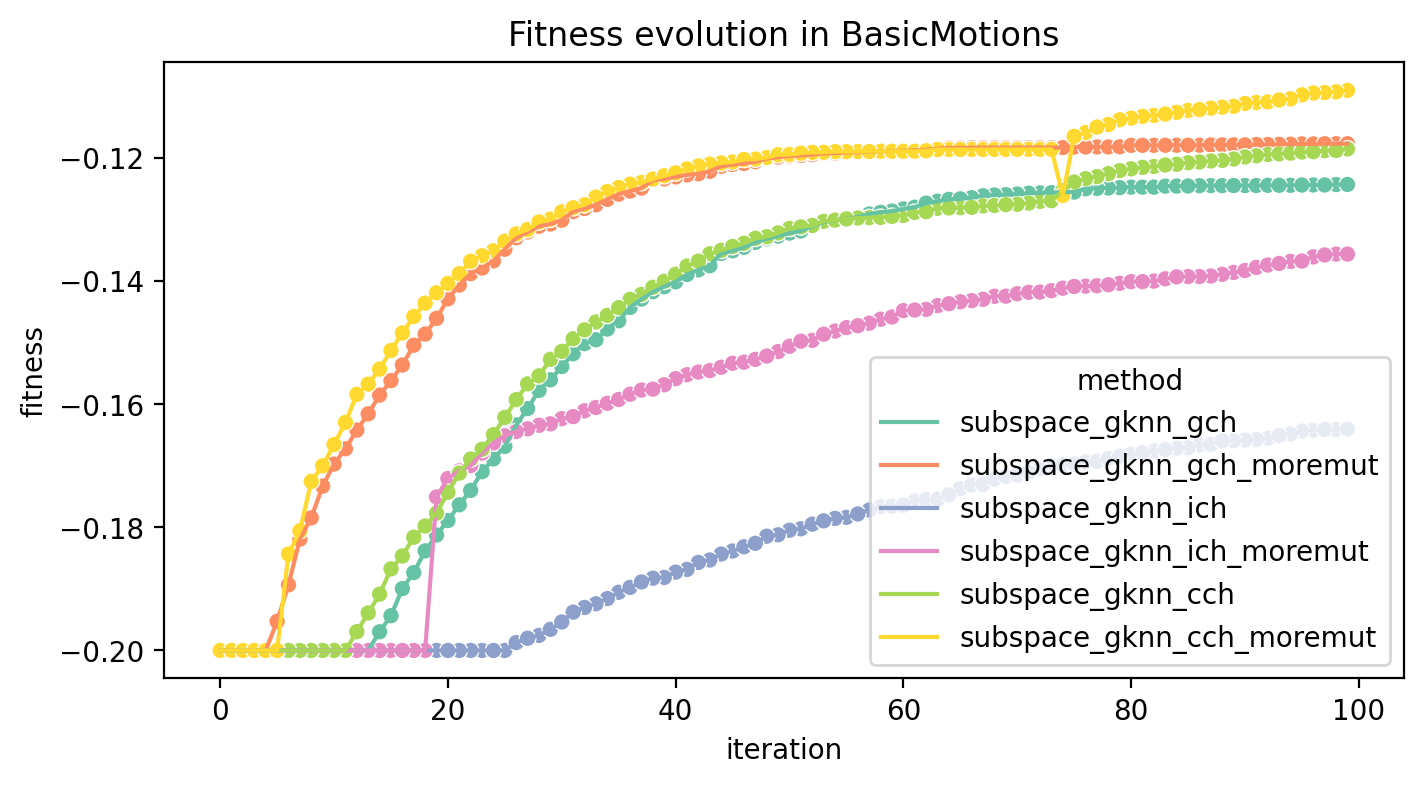

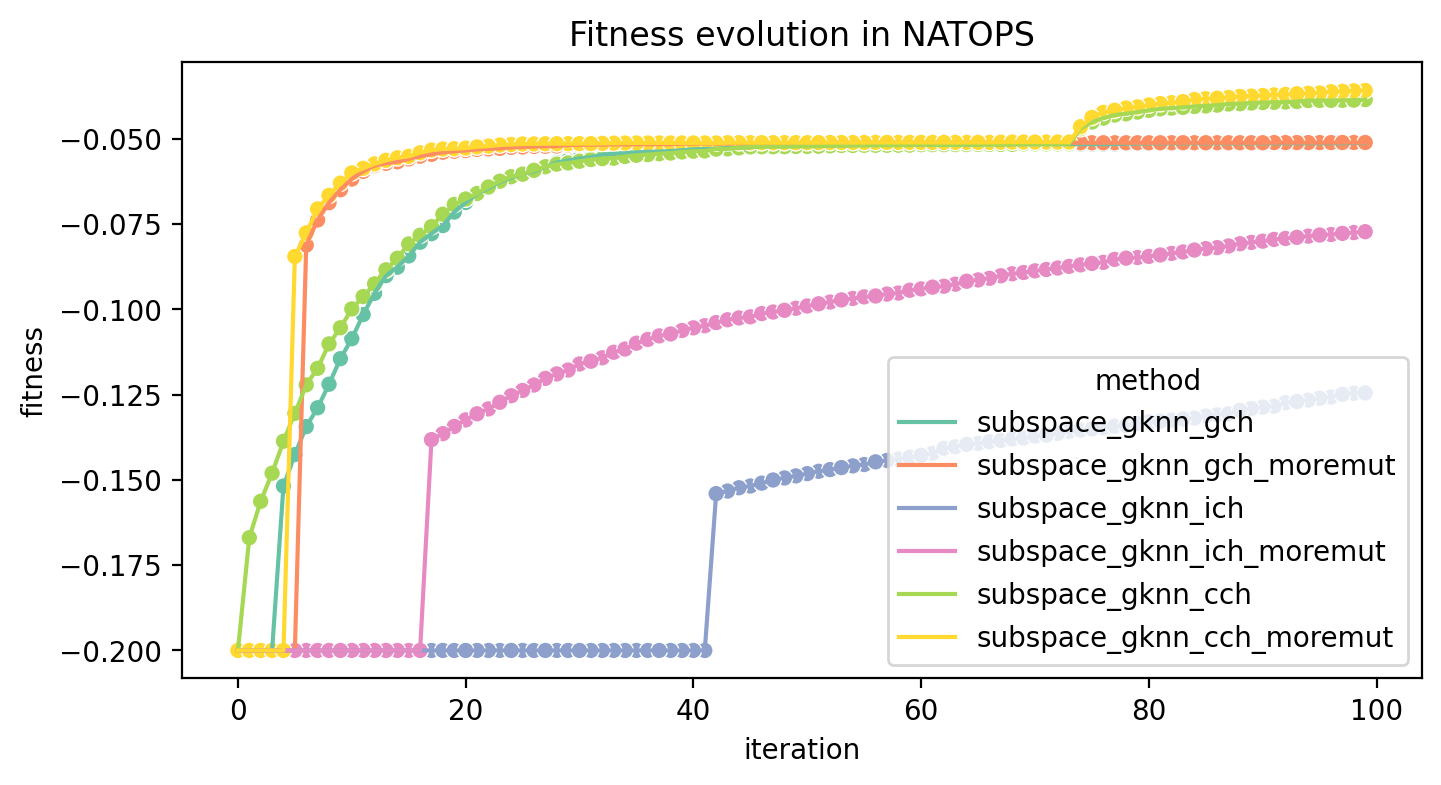

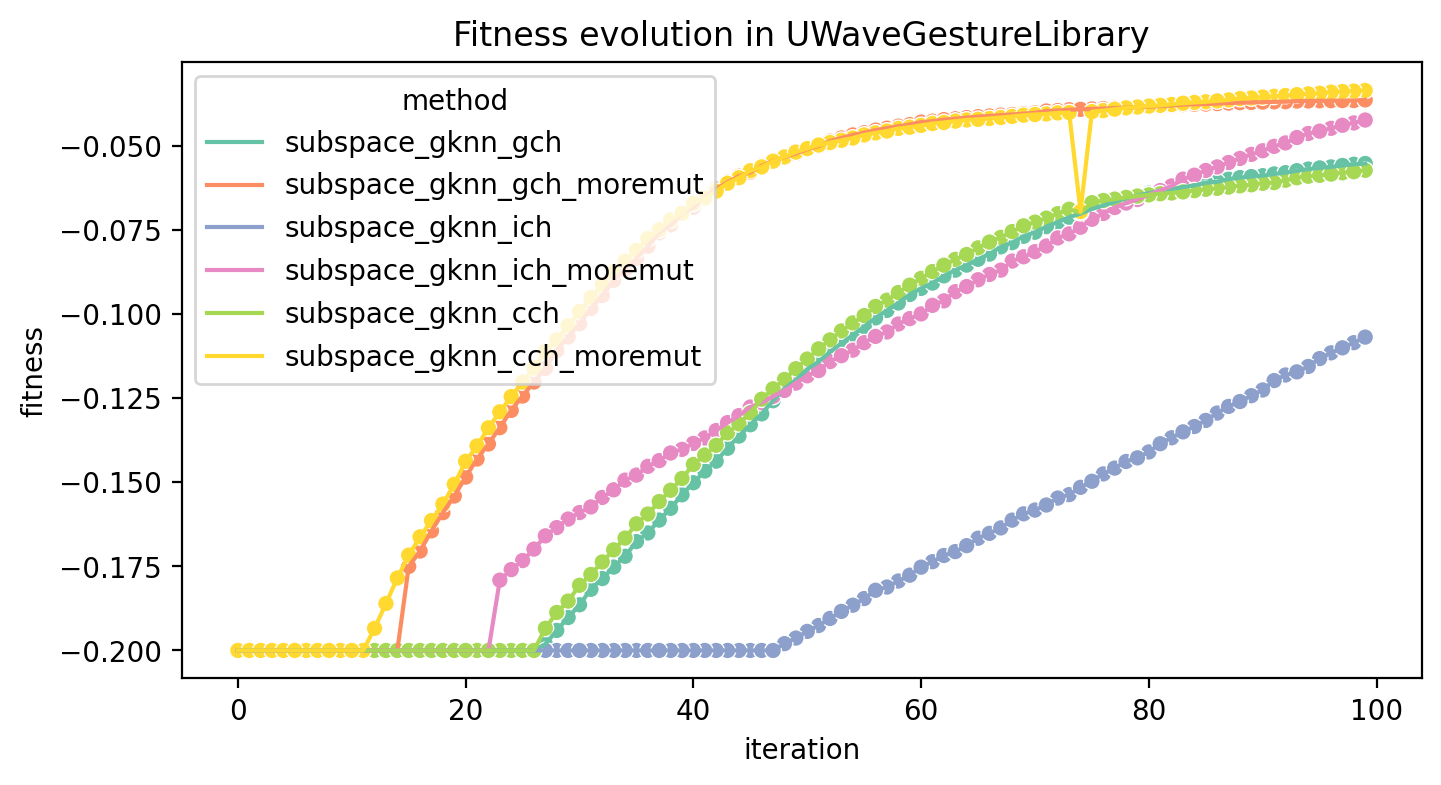

In [20]:
import seaborn as sns

aux_df = all_fitness_curves_df.copy()
methods_order = dict(zip(list(methods.values()), list(range(len(methods)))))

for dataset in DATASETS:
    dataset_fitness_df = aux_df[aux_df['dataset'] == dataset]
    dataset_fitness_mean_df = dataset_fitness_df.groupby(['iteration', 'method'])['fitness'].mean().reset_index()
    dataset_fitness_mean_df['method_ord'] = dataset_fitness_mean_df['method'].map(methods_order)
    dataset_fitness_mean_df = dataset_fitness_mean_df.sort_values('method_ord', ascending=True)
    # Clip values for visualization
    dataset_fitness_mean_df['fitness'].clip(lower=-0.2, upper=None, inplace=True)

    plt.figure(figsize=(8, 4), dpi=200) 
    sns.lineplot(data=dataset_fitness_mean_df, x="iteration", y="fitness", hue="method", palette="Set2").set_title(f'Fitness evolution in {dataset}')
    sns.scatterplot(data=dataset_fitness_mean_df, x="iteration", y="fitness", hue="method", palette="Set2", legend=False)
    plt.show()